In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from numerapi import NumerAPI
import pandas as pd
import numpy as np
import os
import pyarrow as pa
from pyarrow.parquet import ParquetFile
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
class Classifer(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1050, 500),
            nn.ReLU(),
            nn.Linear(500, 250),
            nn.ReLU(),
            nn.Linear(250,125),
            nn.ReLU(),
            nn.Linear(125, 5),
            nn.Softmax(dim=1)    
        )

    def forward(self, x):
        x = self.net(x)
        return x

In [3]:
tr_data_path = os.path.join('data', 'numerai_training_data.parquet')
pf = ParquetFile(tr_data_path)

In [4]:
def create_ft_and_trg_tensors(batch: pa.lib.RecordBatch, le=None):
    df: pd.DataFrame = batch.to_pandas()
    fc = [i for i in df.columns if 'feature' in i]
    ft = torch.tensor(df[fc].values, dtype=torch.float32)
    tl = df['target'].values
    if le is not None:
        tl = le.fit_transform(tl)
    tt = torch.tensor(tl, dtype=torch.long)
    return ft, tt

In [5]:
model = Classifer().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 
criterion = nn.CrossEntropyLoss()

In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

EPOCHS = 3

t_losses = []
for k in tqdm(range(EPOCHS)):
    epoch_loss = 0
    for i, batch in enumerate(pf.iter_batches(batch_size=256)):
        print(f'{i}/9418\r',end='')
        features, target = create_ft_and_trg_tensors(batch, le=le)
        features, target = features.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        pred = model(features)
        loss = criterion(pred, target)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
    t_losses.append(epoch_loss)
    print()


    

  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [02:54<05:48, 174.42s/it]

9422/9418


 67%|██████▋   | 2/3 [05:41<02:49, 169.89s/it]

100%|██████████| 3/3 [08:32<00:00, 170.69s/it]

9422/9418


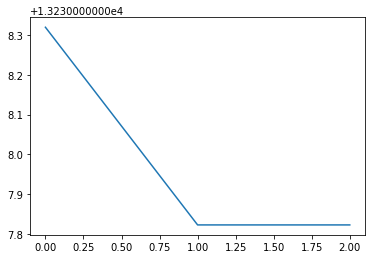

In [7]:
from matplotlib import pyplot as plt
plt.plot(t_losses)